# Jukes-Cantor Model

Nucleotide substitution model with same probabilities for all transitions, with $\mathcal{S}$ = $\{$A, G, C, T$\}$ and parameter inference for the phylogenetic trees with backwards filtering following https://arxiv.org/abs/2203.04155.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
print(sys.executable)

import hyperiax
import jax
import math
import numpy as np
from Bio import Phylo
from io import StringIO
from functools import reduce
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
from jax import numpy as jnp
from hyperiax.execution import LevelwiseTreeExecutor
from hyperiax.models import UpLambda
from hyperiax.models.functional import product_fuse_children
from hyperiax.mcmc import Parameter, ParameterStore
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.plotting import trace_plots

/Users/sara/anaconda3/envs/hyperiax/bin/python


In [3]:
key = PRNGKey(42)

In [4]:
# Updated UniformParameter class for later analysis
class UniformParameter(Parameter):
    def __init__(self, value, min=0., max=1., keep_constant=False) -> None:
        super().__init__(value)
        self.min = min
        self.max = max
        self.keep_constant = keep_constant

    def propose(self, key):
        if self.keep_constant:
            return self

        return UniformParameter(jax.random.uniform(key, minval=self.min, maxval=self.max), self.min, self.max,
                                self.keep_constant)

    def update(self, value, accepted):
        if accepted:
            self.value = value

    def log_prior(self):
        return 0.

In [5]:
# Jukes-Cantor transition matrix 
def jukes_cantor_matrix(alpha):
    """
    Generates the Jukes-Cantor matrix for a given alpha value.

    Assume
     i) each base in the sequence has an equal probability of being substituted, and
     ii) if a nucleotide substitution occurs, all other nucleotides have the same probability to replace it

    Input:
        alpha: The probability of substitution

    Output:
        matrix: Jukes-Cantor transition matrix.
    """

    # 4x4 Transition matrix
    matrix = jnp.array([[1 - 3 * alpha, alpha, alpha, alpha],
                        [alpha, 1 - 3 * alpha, alpha, alpha],
                        [alpha, alpha, 1 - 3 * alpha, alpha],
                        [alpha, alpha, alpha, 1 - 3 * alpha]])

    # print(f"kernel :\n{matrix}")
    return matrix

# Create tree.
First, we initialize the tree with for each node the type, value, and log_sum (norm).

Tree: HypTree with 7 levels and 64 nodes
Newick string:
((((((G,C),(A,T)),((C,A),(G,T))),(((A,G),(C,T)),((A,G),(T,A)))),((((T,C),(G,A)),((A,C),(C,T))),(((T,C),(A,C)),((A,T),(G,A)))))x0)prior;


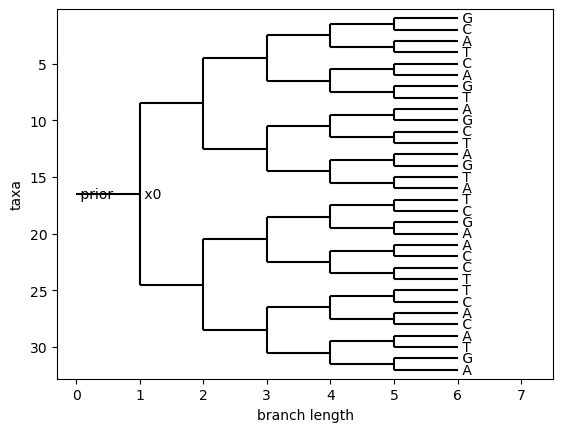

In [6]:
from hyperiax.tree import HypTree, TreeNode
from hyperiax.tree.childrenlist import ChildList

# Define it as a Newick Tree
newick_string = "(((((G,C),(A,T)),((C,A),(G,T))),(((A,G),(C,T)),((A,G),(T,A)))),((((T,C),(G,A)),((A,C),(C,T))),(((T,C),(A,C)),((A,T),(G,A)))));"
# newick = Phylo.read(StringIO(newick_string), "newick")
tree_newick = hyperiax.tree.builders.tree_from_newick(newick_string)

# Or create a random symmetric tree
# tree_newick = hyperiax.tree.builders.symmetric_tree(h=5, degree=2)

# Or create a random not symmetric tree
# tree_newick = hyperiax.tree.builders.asymmetric_tree(h=5)

# Prior Data
prior = TreeNode(); prior.name = "prior"
# Root Data
x0 = tree_newick.root; x0.name = "x0"
x0.parent = prior; prior.children = ChildList([x0])
x0.children = tree_newick.root.children

tree = HypTree(prior)
print('Tree:', tree)

# set types to select the right transitions
# types
troot = 0; tinner_node = 1; tleaf_node = 2

for i in tree.iter_bfs():
    i['type'] = tinner_node
    i['log_sum'] = 0

for i in tree.iter_leaves():
    i['type'] = tleaf_node

tree.root['type'] = troot
x0['type'] = troot

# number of states
R = 4

# root value
tree.root['value'] = jnp.zeros(R)

# observations
nucleotides = ['A', 'G', 'C', 'T']
for i in tree.iter_leaves():
    if i.name in nucleotides:
        i['value'] = jnp.eye(R)[nucleotides.index(i.name)]
    else:
        i['value'] = jnp.eye(R)[np.random.choice(4)]
        i.name = nucleotides[jnp.argmax(i['value'])]

Phylo.draw(Phylo.read(StringIO(tree.to_newick()), "newick"), branch_labels=lambda c: c.branch_length, do_show=False)
print(f"Newick string:\n{tree.to_newick()}")

for i, node in enumerate(tree.iter_bfs(), start=-1):
    if node.name is None:
        node.name = f'x_{i}' if node.name is None else f'{node.name}'

# root, initial state prior
pi1 = 0.9; pi2 = 0.08; pi3 = 0.01; pi4 = 0.01
km10 = lambda params: jnp.diag([pi1, pi2, pi3, pi4])

# inner node
kst = lambda params: jukes_cantor_matrix(params['alpha'])

# leaves
lambdi = lambda params: jnp.eye(R)

# using jax.lax.cond instead of python ifs
def transition(value, type, params):
    return jax.lax.cond(type == tinner_node,
                        lambda: jnp.dot(kst(params), value),
                        lambda: jax.lax.cond(type == tleaf_node,
                                             lambda: jnp.dot(kst(params), jnp.dot(lambdi(params), value)),
                                             lambda: jnp.array([pi1, pi2, pi3, pi4])
                                            )
                       )

Parameter for the transition kernel.

In [7]:
# parameters, alpha with uniform prior
params = ParameterStore({
    'alpha': UniformParameter(value=0.2),  
})

true_params = ParameterStore({
    'alpha': UniformParameter(value=0.2),  
})

We now define the backwards filter through the up and fuse functions. In this case, the up operation is first a matrix multiplication and then a dot product of the children.

In [8]:
# backwards filter. The operation is vmap'ed over the batch dimension (leading dimension)
# @jax.jit
def up(value, type, params, **args):
    def f(value, type):
        return {'value': transition(value, type, params)}
    return jax.vmap(f)(value, type)
        
def norm_product_fuse(**kwargs):
    value = reduce(lambda x, y: x * y, kwargs['child_value']).reshape(-1)
    new_value = value / jnp.linalg.norm(value)
    log_sum = math.log(jnp.linalg.norm(value))
    return {'value': new_value, 'log_sum': log_sum}


We create the model and executor for the backwards filter (up) with the normalized product of the values after joining them.

In [9]:
# create model and executor
save_tree = tree.copy()
upmodel = UpLambda(up_fn=up, fuse_fn=norm_product_fuse)
upexec = LevelwiseTreeExecutor(upmodel)

In [10]:
# execture backwards filter
utree = upexec.up(tree, params.values())

# It also normalizes the prior right now so
utree.root.data['log_sum'] = 0
utree.root.data['value'] = jnp.array([pi1, pi2, pi3, pi4])

# print results
total_log_sum = 0
for node in utree.iter_bfs():
    print(node.data)
    total_log_sum += node.data['log_sum']


{'type': 0, 'log_sum': 0, 'value': Array([0.9 , 0.08, 0.01, 0.01], dtype=float32)}
{'type': 0, 'log_sum': -0.693174301041075, 'value': Array([0.50106907, 0.49893877, 0.50005877, 0.4999312 ], dtype=float32)}
{'type': 1, 'log_sum': -0.6933182605237932, 'value': Array([0.502752  , 0.49990755, 0.49741867, 0.49990755], dtype=float32)}
{'type': 1, 'log_sum': -0.6934752983495439, 'value': Array([0.502579  , 0.49477488, 0.5028667 , 0.49973714], dtype=float32)}
{'type': 1, 'log_sum': -0.6931471805599453, 'value': Array([0.5, 0.5, 0.5, 0.5], dtype=float32)}
{'type': 1, 'log_sum': -0.6974035337706067, 'value': Array([0.51368624, 0.49946654, 0.48702434, 0.49946654], dtype=float32)}
{'type': 1, 'log_sum': -0.6974035337706067, 'value': Array([0.49946654, 0.48702434, 0.51368624, 0.49946654], dtype=float32)}
{'type': 1, 'log_sum': -0.7020160462032011, 'value': Array([0.513321  , 0.486678  , 0.50053364, 0.49911138], dtype=float32)}
{'type': 1, 'log_sum': -0.8029619491774246, 'value': Array([0.5, 0.5, 0

# Likelihood Computation

In [11]:
# Compute Log-Likelihood
prior_vec = utree.root.data['value']
h0_vec = utree.root.children[0].data['value']

log_lik = math.log(jnp.dot(prior_vec, h0_vec)) + total_log_sum
print(f"The log-likelihoog is {log_lik}")

The log-likelihoog is -45.03080363486218


# Likelihood Comparison

In [12]:
likelihood = []
alpha_range = np.linspace(0.02, 0.32, 100)
for new_alpha in alpha_range:
    # Update alpha
    params['alpha'].update(float(new_alpha), True)

    # execture backwards filter
    new_tree = upexec.up(save_tree, params.values())

    # Compute Log-Likelihood
    total_log_sum = 0
    for node in new_tree.iter_bfs():
        total_log_sum += node.data['log_sum']

    # Compute Likelihood
    prior_vec = new_tree.root.data['value']
    h0_vec = new_tree.root.children[0].data['value']

    new_lik = math.log(jnp.dot(prior_vec, h0_vec)) + total_log_sum
    likelihood.append(new_lik)
params['alpha'].update(true_params['alpha'].value, True)

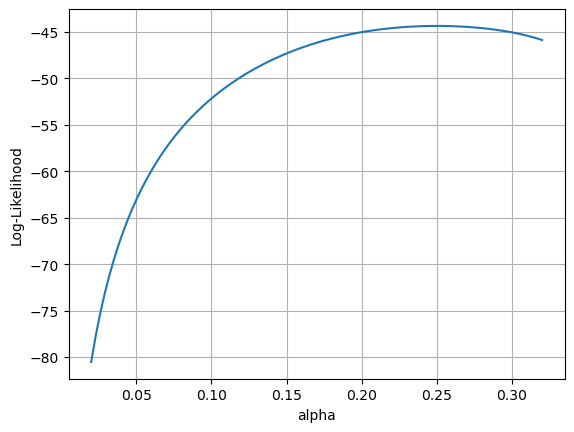

In [13]:
plt.plot(alpha_range, likelihood)
plt.xlabel('alpha')
plt.ylabel('Log-Likelihood')
plt.grid()
plt.savefig("JC_LogLike.png")
plt.show()